In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, 
MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

image_dim = 48
data_dir = "./images/"

In [9]:
batch_size = 128

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_loader = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(image_dim, image_dim),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_loader = val_datagen.flow_from_directory(
    os.path.join(data_dir, "validation"),
    target_size=(image_dim, image_dim),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [10]:
num_classes = 7

model = Sequential()

# 1st CNN Block
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(image_dim, image_dim, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN Block
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN Block
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th CNN Block
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully Connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully Connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    filepath="./model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

callbacks = [early_stop_cb, checkpoint_cb, lr_scheduler_cb]

epochs = 48

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [12]:
history = model.fit(
    train_loader,
    steps_per_epoch=train_loader.n // train_loader.batch_size,
    epochs=epochs,
    validation_data=val_loader,
    validation_steps=val_loader.n // val_loader.batch_size,
    callbacks=callbacks
)


Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.7528 - accuracy: 0.3251
Epoch 1: val_accuracy improved from -inf to 0.31832, saving model to .\model.h5
225/225 [==============================] - 563s 3s/step - loss: 1.7528 - accuracy: 0.3251 - val_loss: 1.8720 - val_accuracy: 0.3183 - lr: 0.0010
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.4237 - accuracy: 0.4463
Epoch 2: val_accuracy improved from 0.31832 to 0.46364, saving model to .\model.h5
225/225 [==============================] - 430s 2s/step - loss: 1.4237 - accuracy: 0.4463 - val_loss: 1.3764 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.2777 - accuracy: 0.5081 
Epoch 3: val_accuracy improved from 0.46364 to 0.51037, saving model to .\model.h5
225/225 [==============================] - 2594s 12s/step - loss: 1.2777 - accuracy: 0.5081 - val_loss: 1.2656 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 4/48
225/225 [========

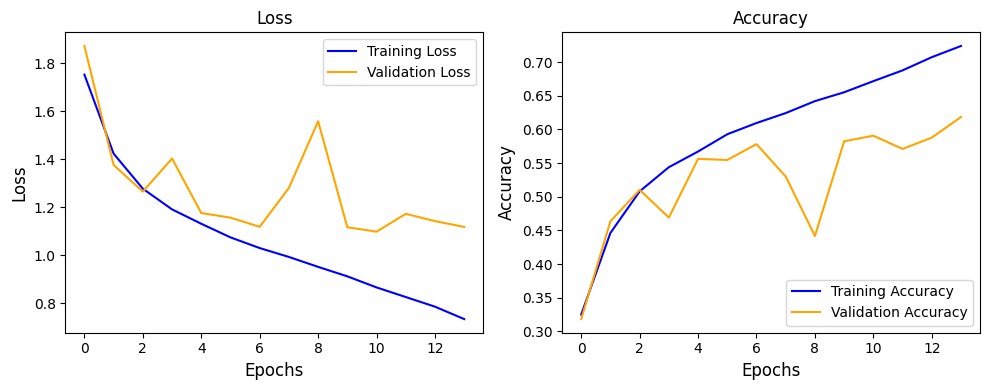

In [14]:
plt.figure(figsize=(10, 4))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.title('Loss Over Epochs')

# Training and Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()